In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%load_ext autoreload
import string
np.random.seed(2) 
torch.manual_seed(2)

In [3]:
%autoreload

In [5]:
lcs = utils.get_data('../../datasets/ZTF_g', test_split=0.0,keep_missing=False, min_length=25)


found 3408 for band='g'
max time:  1687.1367
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(2831, 1, 1962, 3)
train size: 2831, valid size: 567, test size: 0


In [7]:
net,optimizer,scheduler,lrs,args,epoch,losses = utils.load_checkpoint('../checkpoints/g/ZTF_g1.154257893562317.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/g/ZTF_g1.154257893562317.h5'
Namespace(data_folder='/home2/fggr82/astr/hetast/src/datasets/ZTF_g', start_col=1, checkpoint=None, seed=2, device='mps', keep_missing=False, net='HeTVAE', mixing='concat', n_union_tp=3500, embed_time=128, num_heads=16, latent_dim=64, num_ref_points=16, rec_hidden=128, width=512, niters=6000, patience=1000, batch_size=2, k_iwae=1, lr=0.0003, beta1=0.9, beta2=0.999, scheduler=True, warmup=10, factor=0.9, lr_patience=40, threshold=0.01, dropout=0.0, inc_errors=False, frac=0.5, mse_weight=5.0, kl_annealing=True, kl_itrs=6000, n_cycles=32, start=0.0, stop=0.1, ratio=0.5, min_length=25, print_at=1, save_at=30, kl_zero=False, const_var=False, var_per_dim=False, num_resamples=0, is_bounded=True, std=0.5)


In [8]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

  0%|                                                                                                                  | 0/1416 [00:00<?, ?it/s]/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/layers.py:83: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1416/1416 [00:16<00:00, 84.90it/s]


In [10]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)

n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

In [11]:
print(zs.shape,disc_path.shape)

(2831, 16, 64) (2831, 16, 64)


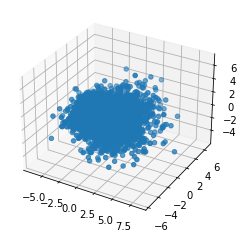

In [12]:
RS = 20150101
pca = PCA(random_state=RS)
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])


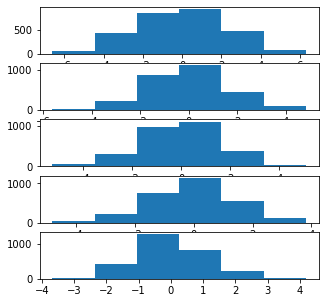

In [13]:
fig, ax = plt.subplots(5, figsize=(5,5))
for i in range(5):
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    bins1 = np.arange(r1,r2, step=(r2-r1)/7)
    ax[i].hist(pca3d[:,i],bins=bins1)
    
plt.savefig('../img/pca_g/pcabins')

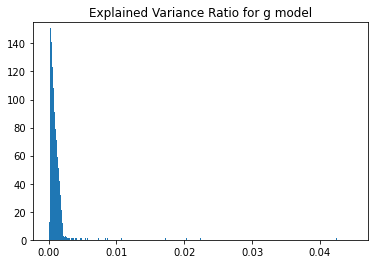

In [14]:
plt.hist(pca.explained_variance_ratio_,bins=np.arange(0.0,0.045,step=0.00015))
plt.ylim(0,155)
plt.title('Explained Variance Ratio for g model')
plt.savefig('../img/pca_g/var_ratio')

In [12]:
# Percent variance explained by the first n PCs? 
n=500

In [13]:
f'{pca.explained_variance_ratio_[:n].sum() * 100} %'

'80.60440544886626 %'

# Bins for different pcs

## uniftp

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.94it/s]


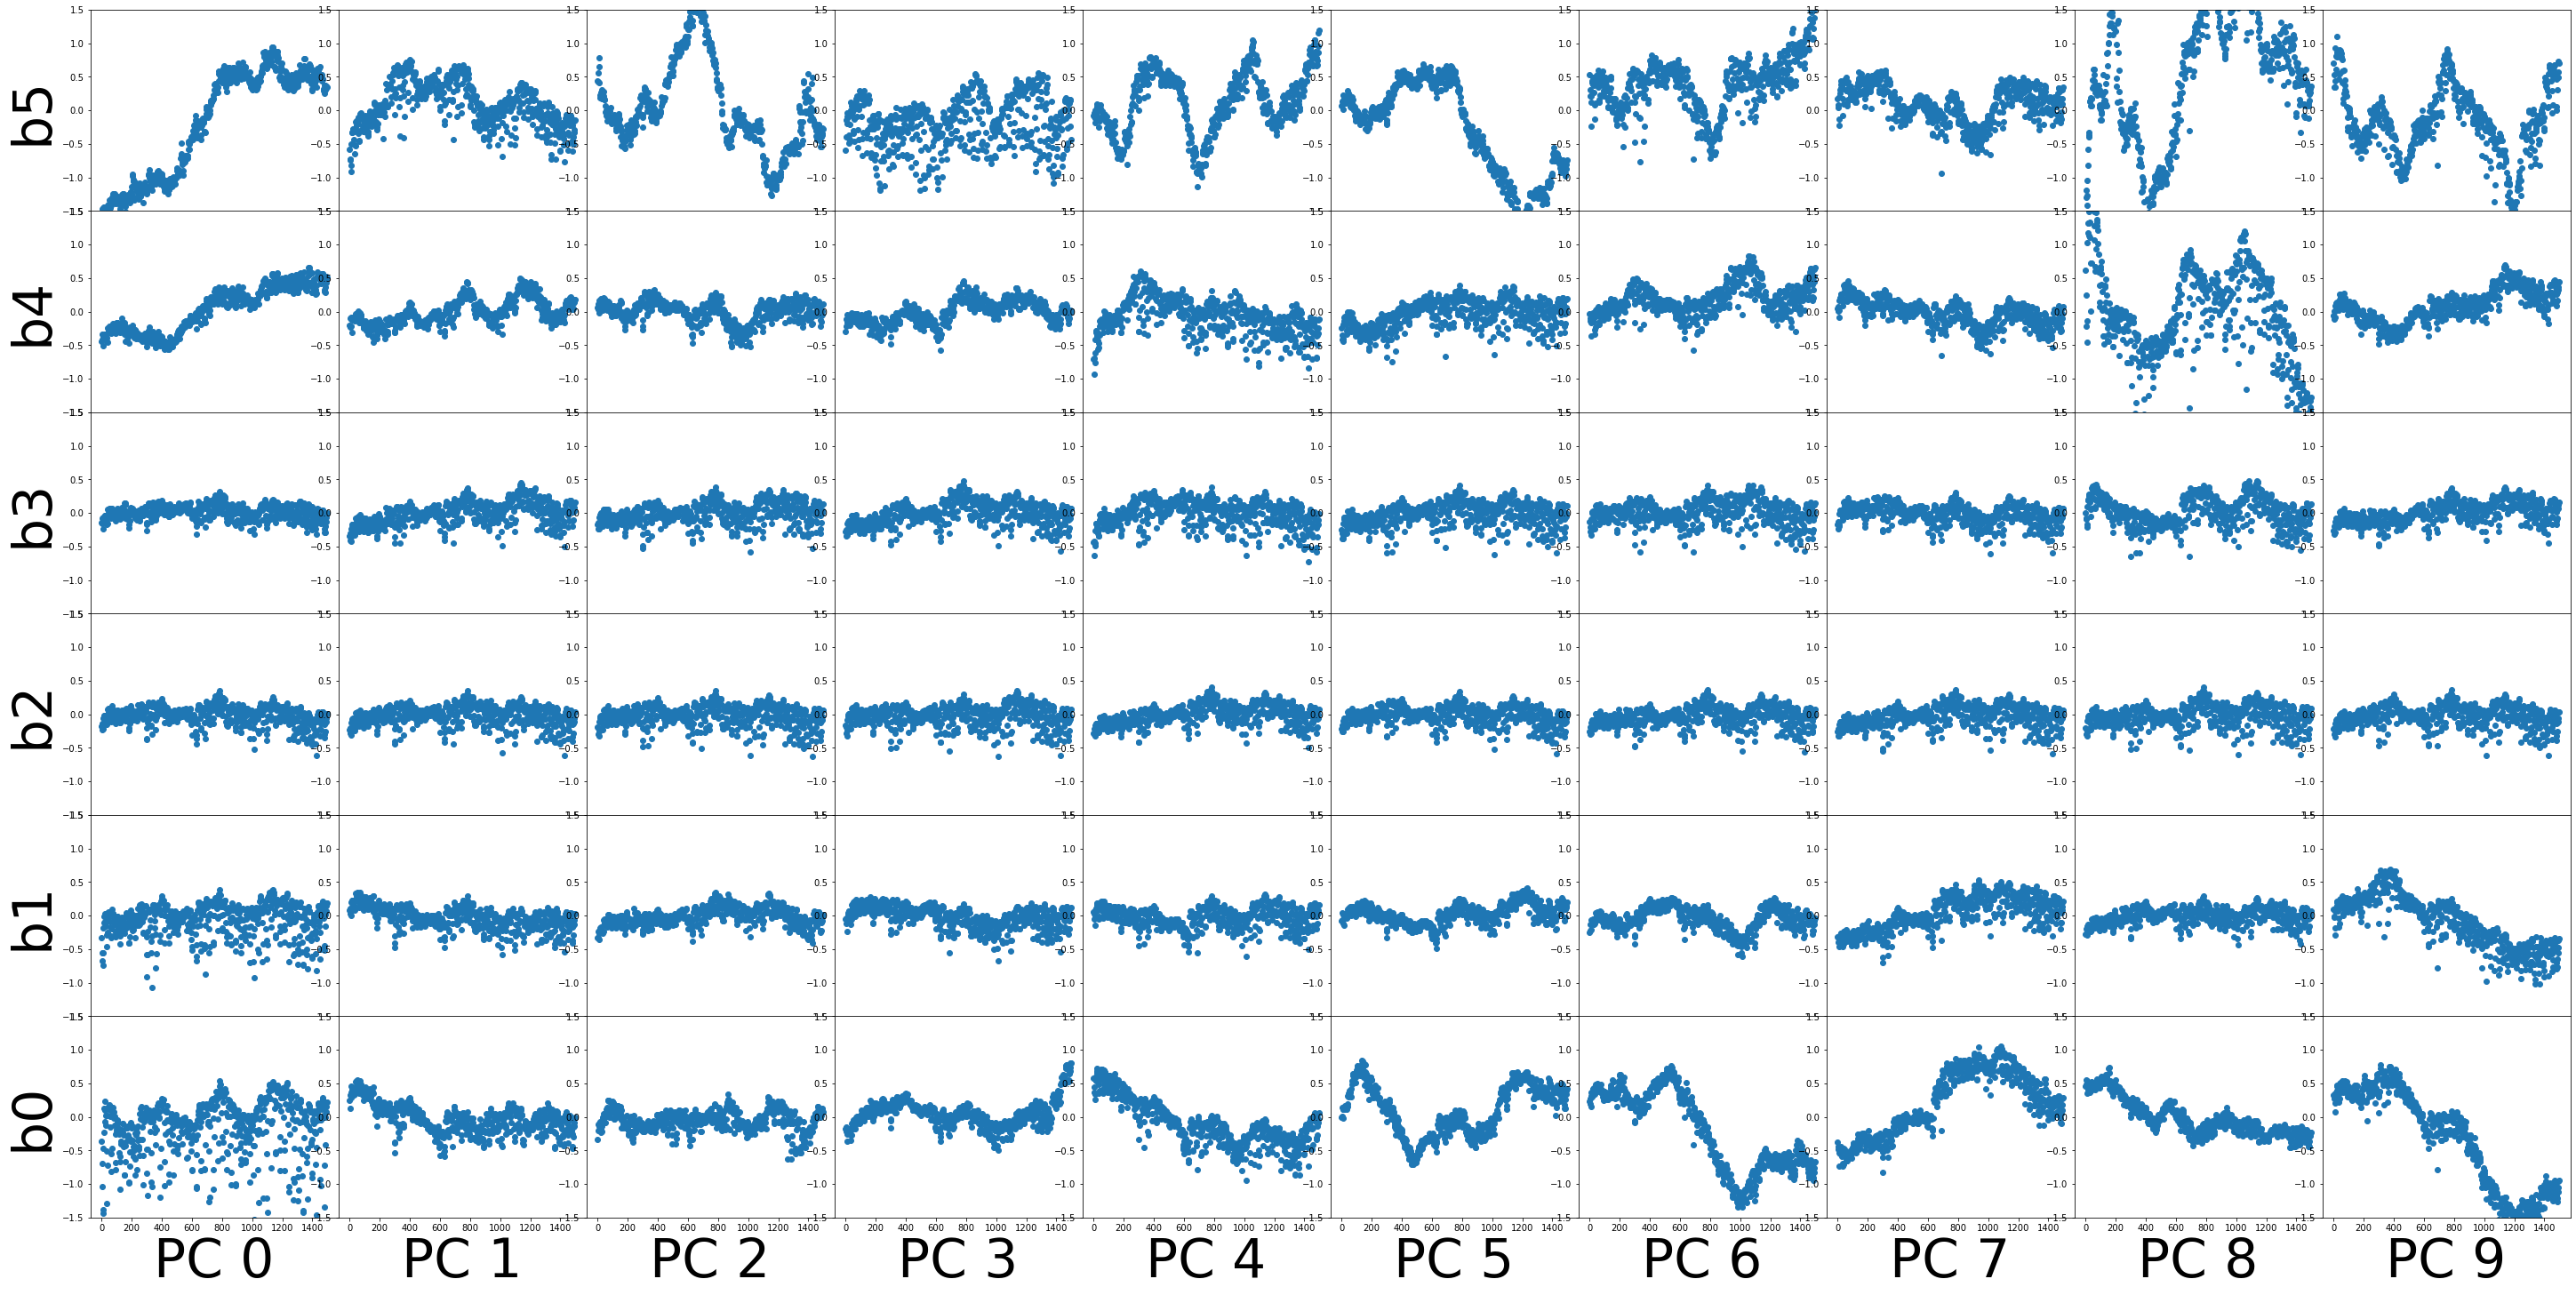

In [15]:
bins = 6
interpols = []
pca_comps = 10
for i in range(pca_comps): # first 4 pcs
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
    bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 
    
    # average light curves across bins 
    avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
     for i in range(1,bins+1)]
    
    avgs = np.array(avgs,dtype=np.float32)
    #print(avgs.shape)
    target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
    target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)
    
    interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
    
    interpols.append(interps)
fs = 60
fig, ax = plt.subplots(bins, pca_comps, figsize=(50,25))
for i in range(pca_comps):
    ax[~0,i].set_xlabel(f'PC {i}',fontsize=fs)
    for bin in range(bins):
        ax[~bin,0].set_ylabel(f'b{bin}',fontsize=fs)
        ax[bin,i].set_ylim(-1.5,1.5)
        interps = interpols[i]
        ax[~bin,i].scatter(interps[bin,0,:,0], interps[bin,0,:,1])
        lc = interpols[i][bin,0,:,:2]
        s2 = round((1/(len(lc)-1)) * ((lc[:,1] - np.mean(lc[:,1]))**2).sum(),4)
#         ax[bin,i].text(0,1.0,s2,fontsize=40)
#         ax[bin,i].vlines(0,-1.5,-1.5 + s2*10, colors='red')
#         rmax = round(lc[:,1].max() +/ lc[:,1].min() ,4)
#         ax[bin,i].text(1400,1.0,round(rmax,4),fontsize=20)


#         rmax = round(lc[:,1].max() +/ lc[:,1].min() ,4)
#         ax[bin,i].text(1400,1.0,round(rmax,4),fontsize=20)
#         ax[bin,i].vlines(1400,-1.5,-1.5+rmax*10, colors='red')
#         ax[bin,i].vlines(1400,-1.5,-1.5+rmax*10, colors='red') 
plt.subplots_adjust(wspace=0, hspace=0)        
plt.savefig('../img/pca_g/recons_uniftp.pdf')


# real tp 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.66it/s]


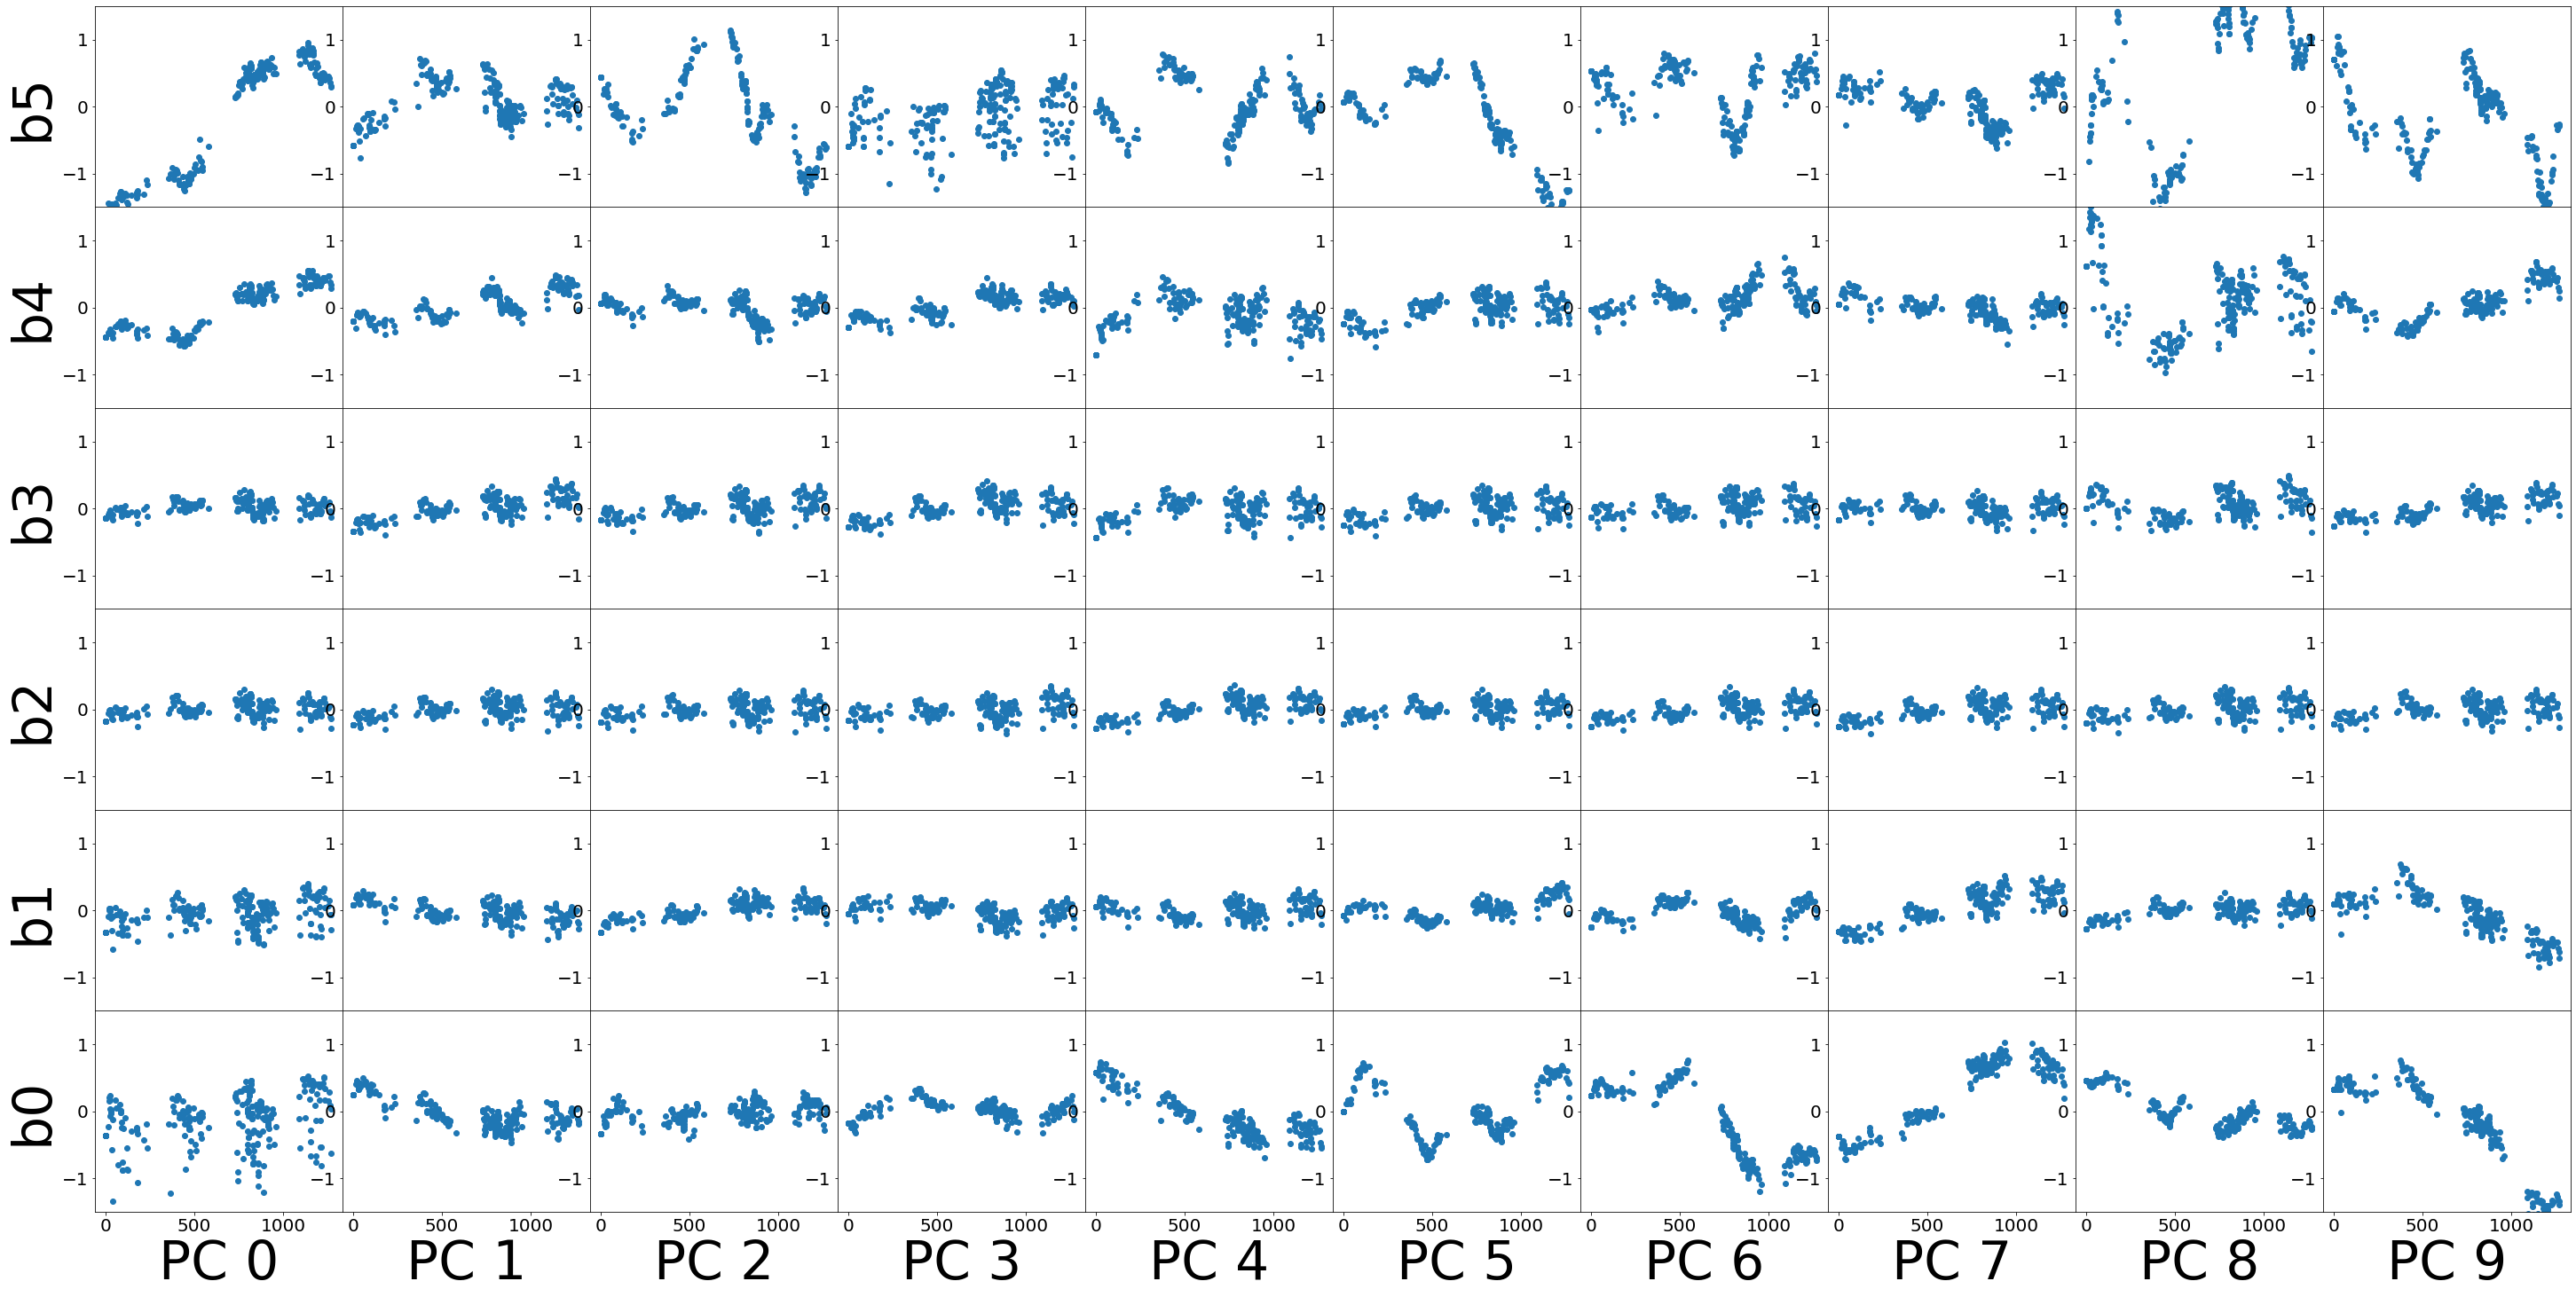

In [44]:
bins = 6
interpols = []
pca_comps = 10
for i in range(pca_comps): # first 4 pcs
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
    bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 
    
    # average light curves across bins 
    avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
     for i in range(1,bins+1)]
    
    avgs = np.array(avgs,dtype=np.float32)
    #print(avgs.shape)
#     target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
    target_tp = lcs.dataset[0,0,:,0]
    target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)
    
    interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
    
    interpols.append(interps)
fs = 60
fig, ax = plt.subplots(bins, pca_comps, figsize=(50,25))
for i in range(pca_comps):
    ax[~0,i].set_xlabel(f'PC {i}',fontsize=fs)
    for bin in range(bins):
        ax[~bin,0].set_ylabel(f'b{bin}',fontsize=fs)
        ax[bin,i].set_ylim(-1.5,1.5)
        interps = interpols[i]
        ax[~bin,i].scatter(interps[bin,0,:,0], interps[bin,0,:,1])
        lc = interpols[i][bin,0,:,:2]
        s2 = round((1/(len(lc)-1)) * ((lc[:,1] - np.mean(lc[:,1]))**2).sum(),4)
#         ax[bin,i].text(0,1.0,s2,fontsize=40)
#         ax[bin,i].vlines(0,-1.5,-1.5 + s2*10, colors='red')
#         rmax = round(lc[:,1].max() +/ lc[:,1].min() ,4)
#         ax[bin,i].text(1400,1.0,round(rmax,4),fontsize=20)


#         rmax = round(lc[:,1].max() +/ lc[:,1].min() ,4)
#         ax[bin,i].text(1400,1.0,round(rmax,4),fontsize=20)
#         ax[bin,i].vlines(1400,-1.5,-1.5+rmax*10, colors='red')
#         ax[bin,i].vlines(1400,-1.5,-1.5+rmax*10, colors='red') 

plt.subplots_adjust(wspace=0, hspace=0) 
# plt.tight_layout()
# plt.savefig('../img/pca_g/recons_realtp.pdf')

# Find which light curves are in which bins!

In [45]:
pc = 5
bin = 6

r1,r2 = np.min(pca3d[:,pc]), np.max(pca3d[:,pc])
bins = np.arange(r1,r2, step=(r2-r1)/bins)
in_which_bin = np.digitize(pca3d[:,pc],bins=bins) 

In [30]:
np.unique(in_which_bin)

array([1, 2, 3, 4, 5, 6])

In [46]:
lc_indexes = np.where([in_which_bin==6])[1]
lc_indexes

array([ 343,  420,  442,  822,  938,  962, 1367, 1416, 2009, 2027, 2254,
       2400, 2488])

In [36]:
lcs_mis = utils.get_data('../../datasets/ZTF_gri',min_length=0, keep_missing=True,norm=False)

found 3408 for band='r'
found 3408 for band='i'
found 3408 for band='g'
max time:  59889.55
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(3177, 3, 4396, 3)
train size: 2859, valid size: 572, test size: 318


In [37]:
np.where(lcs_mis.valid_files_df.index == '153311.13+335102.9')

(array([1546]),)

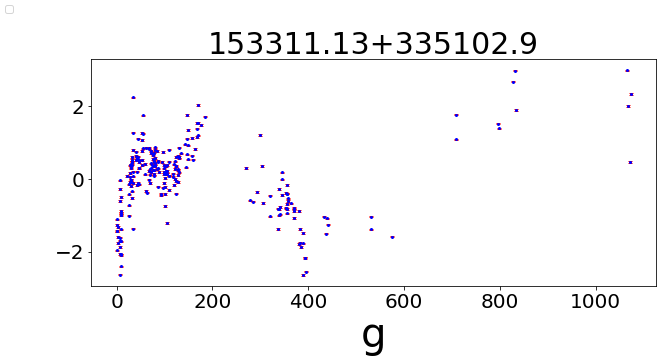

In [35]:
utils.preview_lcs(lcs,[1137],figsize=[10,5])



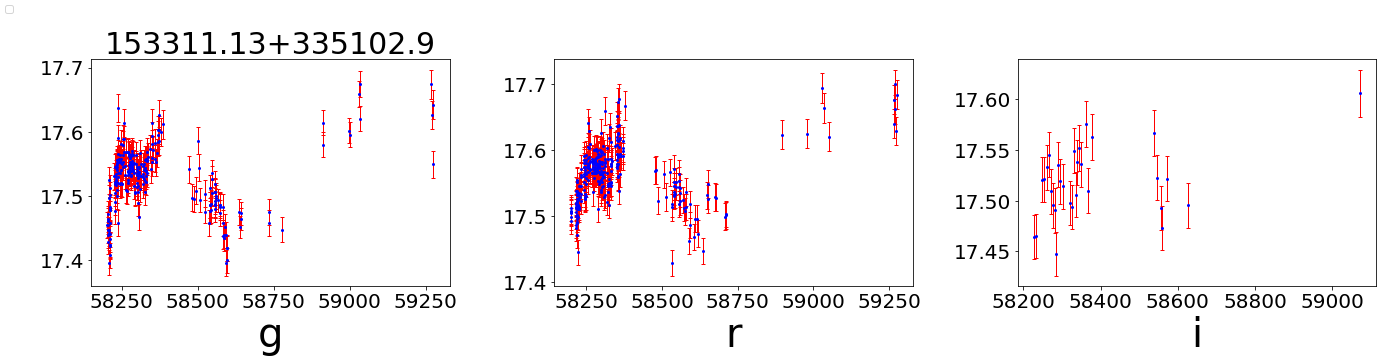

In [49]:
utils.preview_lcs(lcs_mis,[1546],figsize=[20,5],save=True, filepath='/Users/mattlowery/Desktop/thes/chapters/4/figures/anomaly_d/pc5bin6')

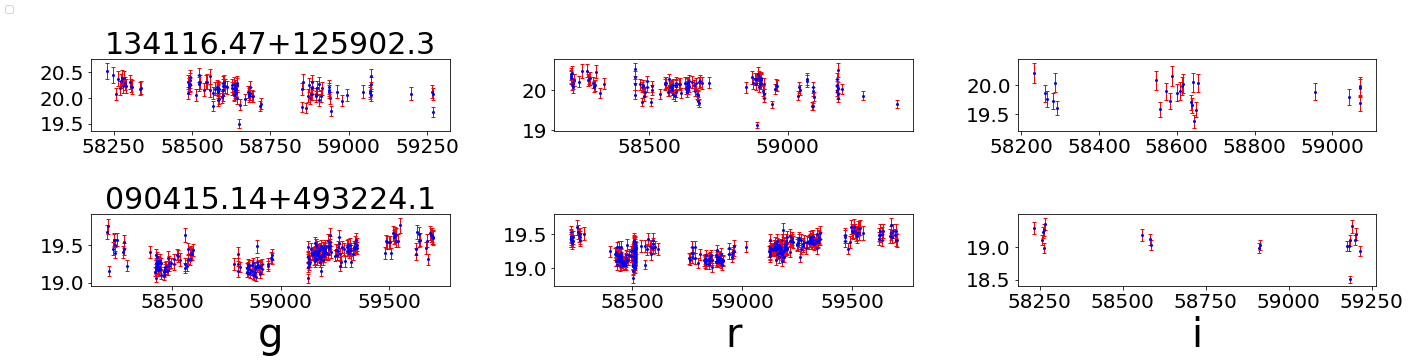

In [47]:

utils.preview_lcs(lcs_mis,[ 343,  420],figsize=[20,5])

In [776]:
lcs.valid_files_df.index[lc_indexes]

Index(['110507.78+065659.5', '130909.71+143752.3', '130324.36+622251.0',
       '162219.43+475132.4', '082438.99+405707.7', '091011.14+542723.5',
       '105044.17+562634.8', '223741.03+164010.8', '120247.26+413031.6',
       '012608.41+002555.2',
       ...
       '125752.58+014415.6', '094751.48+395710.0', '011758.83+002021.4',
       '122605.09+363357.1', '030422.39+002231.8', '095155.67+220947.5',
       '155137.33+225051.1', '125629.34+420010.8', '161033.12+202420.1',
       '012544.51-043424.2'],
      dtype='object', length=293)

# BLEND THE FIRST TWO PCS!

In [15]:
bins = 7
interpols = []
r1_1,r2_1 = np.min(pca3d[:,0]), np.max(pca3d[:,0])
r1_2,r2_2 = np.min(pca3d[:,1]), np.max(pca3d[:,1])
bins1 = np.arange(r1_1,r2_1, step=(r2_1-r1_1)/bins)
bins2 = np.arange(r1_2,r2_2, step=(r2_2-r1_2)/bins)
in_which_1 = np.digitize(pca3d[:,0],bins=bins1) - 1
in_which_2 = np.digitize(pca3d[:,1],bins=bins2) - 1 
avgs= []
for i in range(bins):
    for j in range(bins):
        
        avg = np.concatenate((zs[np.logical_and(in_which_1==i,in_which_2==j)].mean(0)[np.newaxis], \
                                disc_path[np.logical_and(in_which_1==i,in_which_2==j)].mean(0)[np.newaxis]),\
                               axis=0)
        avgs.append(avg)
        
avgs = np.array(avgs,dtype=np.float32)
target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(bins**2,axis=0)
interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)


/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_1192/4040813457.py:13: RuntimeWarning: Mean of empty slice.
  avg = np.concatenate((zs[np.logical_and(in_which_1==i,in_which_2==j)].mean(0)[np.newaxis], \
/var/folders/f7/kj3k_2wx32z5vc93mdwsypn00000gn/T/ipykernel_1192/4040813457.py:14: RuntimeWarning: Mean of empty slice.
  disc_path[np.logical_and(in_which_1==i,in_which_2==j)].mean(0)[np.newaxis]),\
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:02<00:00,  9.47it/s]


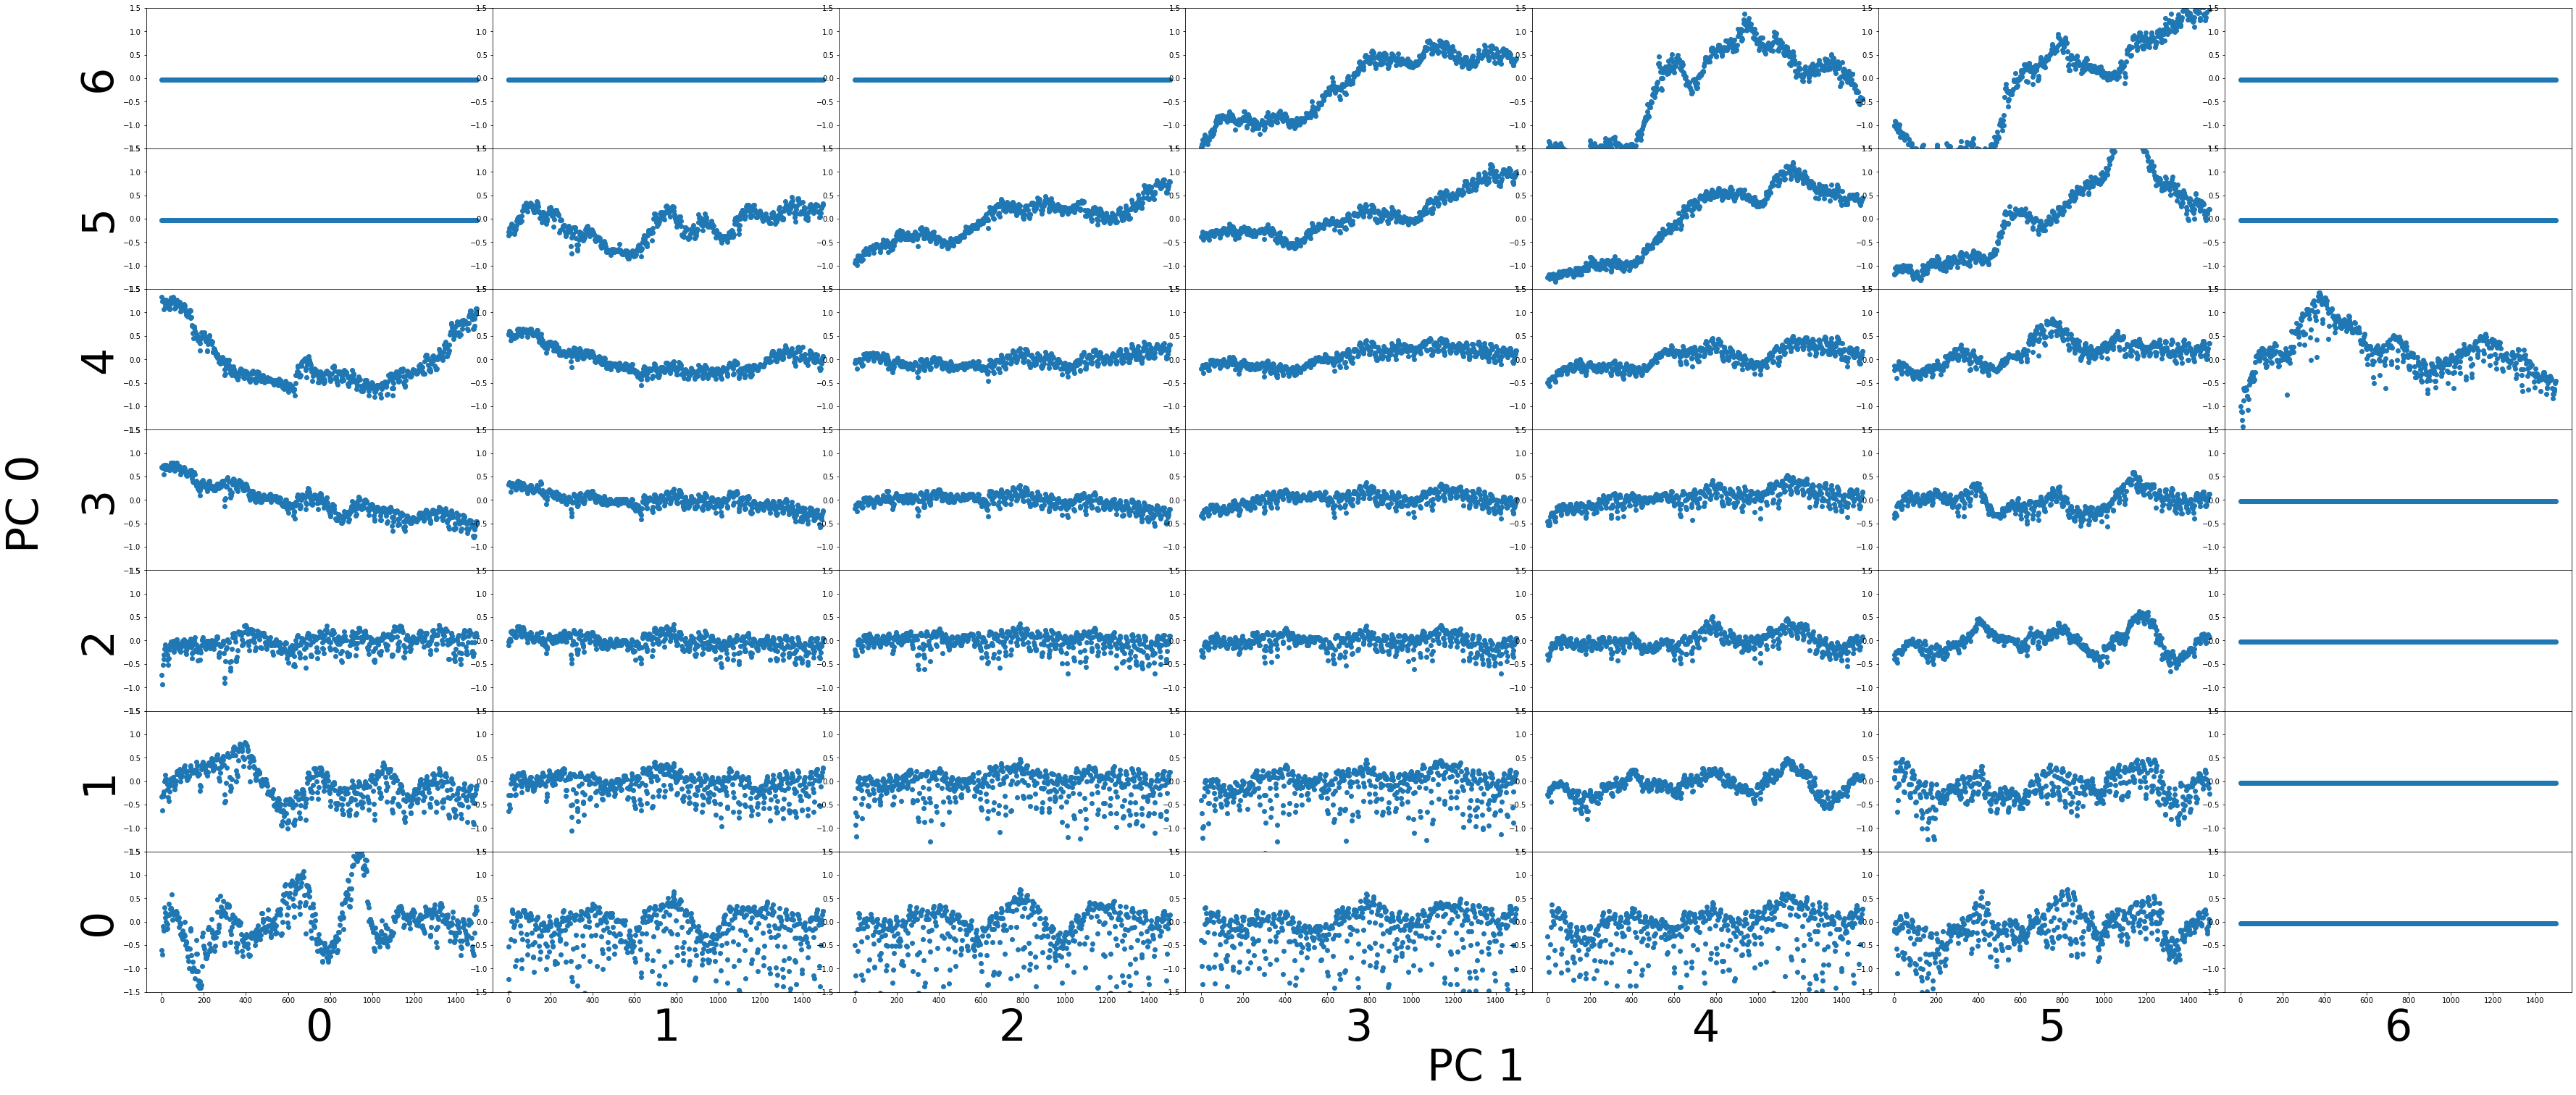

In [16]:
interps = interps.reshape((bins,bins,-1,3))
fig,ax = plt.subplots(bins,bins,figsize=(60,25))
for i in range(bins):
    ax[~i,0].set_ylabel(i,fontsize=fs)
    for j in range(bins):
        ax[~0,j].set_xlabel(j,fontsize=fs)
        ax[~i,j].scatter(interps[i,j,:,0],interps[i,j,:,1])
        ax[i,j].set_ylim(-1.5,1.5)
        lc = interps[i,j,:,:2]
#         s2 = round((1/(len(lc)-1)) * ((lc[:,1] - np.mean(lc[:,1]))**2).sum(),4)
#         ax[~i,j].text(0,1.0,s2,fontsize=40)
#         ax[~i,j].vlines(-50,-1.5,-1.5 + s2*10, colors='red')

fig.supxlabel('PC 1',x=0.55, y=0.05, fontsize=60)
fig.supylabel('PC 0',x=0.08,y=0.5, fontsize=60)
    
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('../img/pca_g/blend_pc12')



In [1]:
plt.scatter(interps[6,5,:,0],interps[6,5,:,1])
plt.rcParams["figure.figsize"] = (20,7)
# plt.savefig('../img/filtered_lcs/bin65recon')

NameError: name 'plt' is not defined

# GET light curves from a given bin

In [49]:
indys = []
for gimme_bin in [(6,3),(6,4),(6,5)]:
    lc_indexes = np.where([np.logical_and(in_which_1==gimme_bin[0], in_which_2==gimme_bin[1])])[1]
    print(lcs.valid_files_df.index[[lc_indexes]], lc_indexes)
    indys.append(lc_indexes)

Index(['142125.66+394328.8', '083331.59+523405.2', '225430.16+281655.4',
       '093410.97+180641.9'],
      dtype='object') [  48  326 1661 1951]
Index(['102734.60+073513.9', '114228.50+103229.3'], dtype='object') [  18 1748]
Index(['100621.69+124533.0'], dtype='object') [1997]


In [53]:
lcs = utils.get_data('../../datasets/ZTF_g', test_split=0.0,keep_missing=False, min_length=25,norm=False)

found 3408 for band='g'
max time:  59889.414
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(2831, 1, 1962, 3)
train size: 2831, valid size: 567, test size: 0


In [879]:
%autoreload

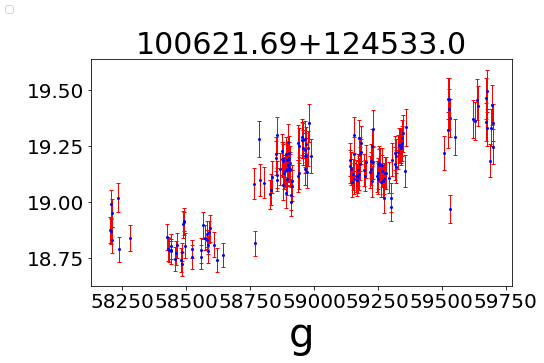

In [67]:
utils.preview_lcs(lcs, indexes=indys[2], figsize=(8,5), fs=30,save=False, filepath='../img/filtered_lcs/bin65')

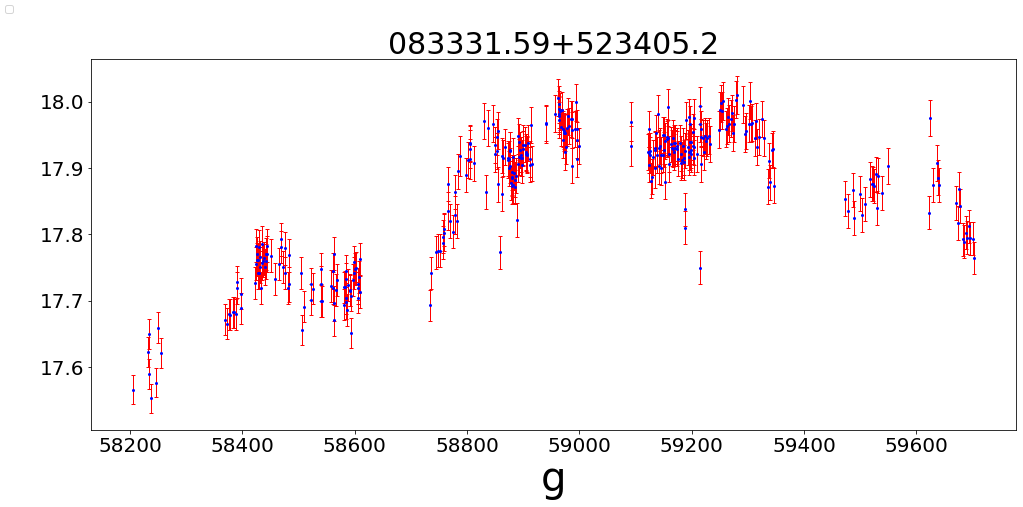

In [867]:
utils.preview_lcs(lcs, indexes=[326], figsize=(15,7), fs=30)

# Exaggerate one of the main features from PCA 8

In [586]:
comp_to_exag = 4
bin_to_exag = 4
## pick the index you want to change by [-1,-2]...
exag_index = np.argsort(pca.components_[comp_to_exag,:])[-1]
exag_amounts = [-500,-100,-10,-1, -0.5, 0,0.5,1.0,10,100,500]

(array([  2.,   5.,   5.,  24., 285., 665.,  26.,   7.,   3.,   2.]),
 array([-0.24696182, -0.19871328, -0.15046474, -0.10221619, -0.05396765,
        -0.00571911,  0.04252944,  0.09077798,  0.13902652,  0.18727507,
         0.23552361]),
 <BarContainer object of 10 artists>)

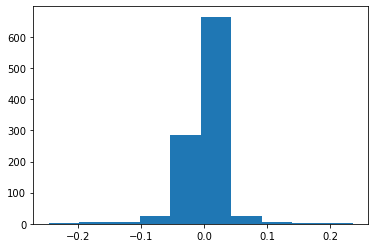

In [587]:
plt.hist(pca.components_[comp_to_exag,:])

(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.76it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.89it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.50it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.49it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.31it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.51it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.34it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.55it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.47it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.68it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.14it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.28it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.05it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.17it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.76it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.57it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.38it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.16it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.17it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.24it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.42it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.43it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.42it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.58it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.50it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.57it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.60it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.35it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.94it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.51it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.58it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.58it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.49it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.01it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.97it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.33it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.49it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.39it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.39it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.42it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.55it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.42it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.04it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.14it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.94it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.49it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.65it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.34it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.65it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.64it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.81it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.58it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.06it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.62it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.51it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.68it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.64it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.29it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.60it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.84it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.85it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.73it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.14it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.99it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.09it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.27it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.62it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.25it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.46it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.43it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.53it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.76it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.47it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 10.60it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.03it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.18it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.05it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.86it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.83it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.45it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.80it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.72it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.82it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.66it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.86it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.70it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.02it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.67it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.25it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.86it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.96it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.69it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.55it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.88it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.23it/s]


(5, 2, 16, 64)
-0.2921642 VALUE of pc4,bin0,latent feature 977
1.737497 VALUE of pc4,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.36it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.69it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.51it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.82it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.64it/s]


(5, 2, 16, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.58it/s]


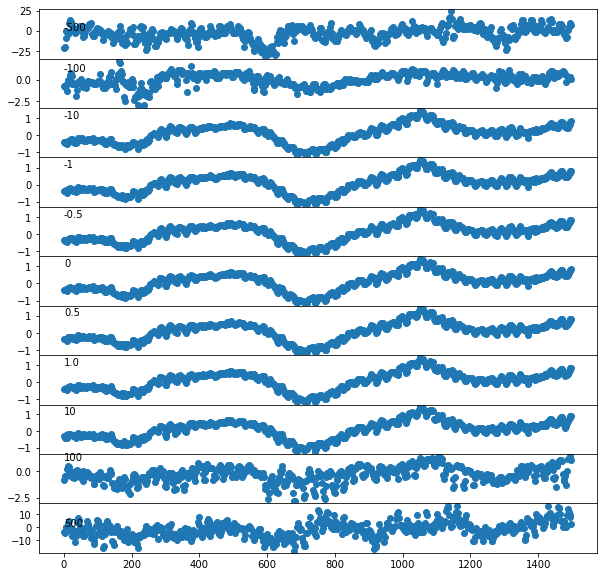

In [588]:
bins = 5
interpols = []
pca_comps = 10
fig, ax = plt.subplots(len(exag_amounts),figsize=(10,10))
exag_interpols = []
for exag_i, exag_amount in enumerate(exag_amounts): 
    for i in range(pca_comps): # first 4 pcs
        r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])

        bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
        bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 

        # average light curves across bins 
        avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
         for i in range(1,bins+1)]

        avgs = np.array(avgs,dtype=np.float32)
        print(avgs.shape)
        target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
        target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)

        if i == comp_to_exag:
            # given z, disc path of bin 4, pc 8, add or subtract some amount from exag_index

            print(avgs[0,0].flatten()[exag_index], f'VALUE of pc{comp_to_exag},bin0,latent feature {exag_index}')
            print(avgs[bin_to_exag,0].flatten()[exag_index], f'VALUE of pc{comp_to_exag},bin {bin_to_exag},latent feature {exag_index}')
            new_i = np.unravel_index(exag_index, (16,64))
            avgs[bin_to_exag,0,new_i[0],new_i[1]] = avgs[bin_to_exag,0,new_i[0],new_i[1]] + exag_amount

        # for just pc8, bin4, 

        interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
        if i == comp_to_exag:
            ax[exag_i].scatter(interps[bin_to_exag,0,:,0], interps[bin_to_exag,0,:,1])
            ax[exag_i].text(0,1,f'{exag_amount}')
        interpols.append(interps)
        
        
    exag_interpols.append(interpols)
    
plt.subplots_adjust(wspace=0, hspace=0) 
plt.savefig('../img/exagpcafeat/exag_one')

# Exaggerate [n,n_1,n_2] of the main features from PCA 8

In [591]:
comp_to_exag = 4
bin_to_exag = 4
n_to_exag = [2,10,100,500,1000]
exag_indexes_per_n = [np.argsort(pca.components_[comp_to_exag,:])[-n:] for n in n_to_exag]
exag_amounts = [-100,-0.5,0,0.5,100,1000]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.60it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.67it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.61it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.50it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.71it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.41it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.53it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[962 927 896 994 902 991 913 960 966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[962 927 896 994 902 991 913 960 966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.65it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[962 927 896 994 902 991 913 960 966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.05it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[962 927 896 994 902 991 913 960 966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.28it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[962 927 896 994 902 991 913 960 966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.35it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[962 927 896 994 902 991 913 960 966 977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.66it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 533  953  958  816  688  230  598  597  129 1006   14  938  768 1013
  662  732    7  871  587   54  110   11  905   38  789  919  866  827
  978  899   34  853  926  774   46 1022  918  834  946  752  837   65
  969  860    1  139  796  781   75  845  990  916  900 1010 1017  947
 1011  998  904  983  996   67  891  131 1002  901  982  785  863  963
  898  968  917  832    3  838  935  964  909  924  930  955  981  980
  849  965  973  988 1019  999  962  927  896  994  902  991  913  960
  966  977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.48it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 533  953  958  816  688  230  598  597  129 1006   14  938  768 1013
  662  732    7  871  587   54  110   11  905   38  789  919  866  827
  978  899   34  853  926  774   46 1022  918  834  946  752  837   65
  969  860    1  139  796  781   75  845  990  916  900 1010 1017  947
 1011  998  904  983  996   67  891  131 1002  901  982  785  863  963
  898  968  917  832    3  838  935  964  909  924  930  955  981  980
  849  965  973  988 1019  999  962  927  896  994  902  991  913  960
  966  977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.57it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 533  953  958  816  688  230  598  597  129 1006   14  938  768 1013
  662  732    7  871  587   54  110   11  905   38  789  919  866  827
  978  899   34  853  926  774   46 1022  918  834  946  752  837   65
  969  860    1  139  796  781   75  845  990  916  900 1010 1017  947
 1011  998  904  983  996   67  891  131 1002  901  982  785  863  963
  898  968  917  832    3  838  935  964  909  924  930  955  981  980
  849  965  973  988 1019  999  962  927  896  994  902  991  913  960
  966  977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.35it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 533  953  958  816  688  230  598  597  129 1006   14  938  768 1013
  662  732    7  871  587   54  110   11  905   38  789  919  866  827
  978  899   34  853  926  774   46 1022  918  834  946  752  837   65
  969  860    1  139  796  781   75  845  990  916  900 1010 1017  947
 1011  998  904  983  996   67  891  131 1002  901  982  785  863  963
  898  968  917  832    3  838  935  964  909  924  930  955  981  980
  849  965  973  988 1019  999  962  927  896  994  902  991  913  960
  966  977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 533  953  958  816  688  230  598  597  129 1006   14  938  768 1013
  662  732    7  871  587   54  110   11  905   38  789  919  866  827
  978  899   34  853  926  774   46 1022  918  834  946  752  837   65
  969  860    1  139  796  781   75  845  990  916  900 1010 1017  947
 1011  998  904  983  996   67  891  131 1002  901  982  785  863  963
  898  968  917  832    3  838  935  964  909  924  930  955  981  980
  849  965  973  988 1019  999  962  927  896  994  902  991  913  960
  966  977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.65it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 533  953  958  816  688  230  598  597  129 1006   14  938  768 1013
  662  732    7  871  587   54  110   11  905   38  789  919  866  827
  978  899   34  853  926  774   46 1022  918  834  946  752  837   65
  969  860    1  139  796  781   75  845  990  916  900 1010 1017  947
 1011  998  904  983  996   67  891  131 1002  901  982  785  863  963
  898  968  917  832    3  838  935  964  909  924  930  955  981  980
  849  965  973  988 1019  999  962  927  896  994  902  991  913  960
  966  977]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.78it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 332  463  320  818  432  474  551  401  683  204  412  629  508  270
  527  236  723  336  761  740  642  369  274  402  600  191  338  345
  222  850  682  424  126  347  716  571  501  415  173  485  993  692
  523  607  297  504  661  512  448  767  931  329  640  396  636  215
  192  536  617 1007  337  477  400  648  680  564  190  578  697  489
  313  665  826  824  140  209   81  164  433  242  121  109  556  280
  210  511  323  820  395  885  654  867  237  247   33  713  621  539
  378  326  851  165  301  439  455  273  475   41  324   77  355  388
  722  410  506  903  676  201  264  305  429  260  302  346  612  633
  354  271  803    9  751  677  894  447  379  979  699  405  470  357
  626  366  696  443  391  325  349  462  670  212  148  497  760  724
  766  660  514  146  419  602  669  272  314  603  235  510  268  651
  549  530  431  581  488  645  102  152  467  655  7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.44it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 332  463  320  818  432  474  551  401  683  204  412  629  508  270
  527  236  723  336  761  740  642  369  274  402  600  191  338  345
  222  850  682  424  126  347  716  571  501  415  173  485  993  692
  523  607  297  504  661  512  448  767  931  329  640  396  636  215
  192  536  617 1007  337  477  400  648  680  564  190  578  697  489
  313  665  826  824  140  209   81  164  433  242  121  109  556  280
  210  511  323  820  395  885  654  867  237  247   33  713  621  539
  378  326  851  165  301  439  455  273  475   41  324   77  355  388
  722  410  506  903  676  201  264  305  429  260  302  346  612  633
  354  271  803    9  751  677  894  447  379  979  699  405  470  357
  626  366  696  443  391  325  349  462  670  212  148  497  760  724
  766  660  514  146  419  602  669  272  314  603  235  510  268  651
  549  530  431  581  488  645  102  152  467  655  7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.64it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 332  463  320  818  432  474  551  401  683  204  412  629  508  270
  527  236  723  336  761  740  642  369  274  402  600  191  338  345
  222  850  682  424  126  347  716  571  501  415  173  485  993  692
  523  607  297  504  661  512  448  767  931  329  640  396  636  215
  192  536  617 1007  337  477  400  648  680  564  190  578  697  489
  313  665  826  824  140  209   81  164  433  242  121  109  556  280
  210  511  323  820  395  885  654  867  237  247   33  713  621  539
  378  326  851  165  301  439  455  273  475   41  324   77  355  388
  722  410  506  903  676  201  264  305  429  260  302  346  612  633
  354  271  803    9  751  677  894  447  379  979  699  405  470  357
  626  366  696  443  391  325  349  462  670  212  148  497  760  724
  766  660  514  146  419  602  669  272  314  603  235  510  268  651
  549  530  431  581  488  645  102  152  467  655  7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.22it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 332  463  320  818  432  474  551  401  683  204  412  629  508  270
  527  236  723  336  761  740  642  369  274  402  600  191  338  345
  222  850  682  424  126  347  716  571  501  415  173  485  993  692
  523  607  297  504  661  512  448  767  931  329  640  396  636  215
  192  536  617 1007  337  477  400  648  680  564  190  578  697  489
  313  665  826  824  140  209   81  164  433  242  121  109  556  280
  210  511  323  820  395  885  654  867  237  247   33  713  621  539
  378  326  851  165  301  439  455  273  475   41  324   77  355  388
  722  410  506  903  676  201  264  305  429  260  302  346  612  633
  354  271  803    9  751  677  894  447  379  979  699  405  470  357
  626  366  696  443  391  325  349  462  670  212  148  497  760  724
  766  660  514  146  419  602  669  272  314  603  235  510  268  651
  549  530  431  581  488  645  102  152  467  655  7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.19it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 332  463  320  818  432  474  551  401  683  204  412  629  508  270
  527  236  723  336  761  740  642  369  274  402  600  191  338  345
  222  850  682  424  126  347  716  571  501  415  173  485  993  692
  523  607  297  504  661  512  448  767  931  329  640  396  636  215
  192  536  617 1007  337  477  400  648  680  564  190  578  697  489
  313  665  826  824  140  209   81  164  433  242  121  109  556  280
  210  511  323  820  395  885  654  867  237  247   33  713  621  539
  378  326  851  165  301  439  455  273  475   41  324   77  355  388
  722  410  506  903  676  201  264  305  429  260  302  346  612  633
  354  271  803    9  751  677  894  447  379  979  699  405  470  357
  626  366  696  443  391  325  349  462  670  212  148  497  760  724
  766  660  514  146  419  602  669  272  314  603  235  510  268  651
  549  530  431  581  488  645  102  152  467  655  7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.13it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 332  463  320  818  432  474  551  401  683  204  412  629  508  270
  527  236  723  336  761  740  642  369  274  402  600  191  338  345
  222  850  682  424  126  347  716  571  501  415  173  485  993  692
  523  607  297  504  661  512  448  767  931  329  640  396  636  215
  192  536  617 1007  337  477  400  648  680  564  190  578  697  489
  313  665  826  824  140  209   81  164  433  242  121  109  556  280
  210  511  323  820  395  885  654  867  237  247   33  713  621  539
  378  326  851  165  301  439  455  273  475   41  324   77  355  388
  722  410  506  903  676  201  264  305  429  260  302  346  612  633
  354  271  803    9  751  677  894  447  379  979  699  405  470  357
  626  366  696  443  391  325  349  462  670  212  148  497  760  724
  766  660  514  146  419  602  669  272  314  603  235  510  268  651
  549  530  431  581  488  645  102  152  467  655  7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.59it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 975  907  945 1004   48  944  970  869  908  910   59  873 1005  856
  112  123  987  858  911  985  956   22  872  921  811 1014   27   15
  923  950   91  951 1015  940   42  843  176  143   21  892   63  187
   16   86   26    8 1023  906  155  890  116  941  846  844  150  857
  170    2  769   79   60  579   53  678  156  149  124    5  608  976
  808  864  805  184  823  106   80   85  181   55  252  251   52  730
  912   39  886  707  780  928  792   58  952  782   47   28 1012  887
   24   19  115  127  747  117    0  188  848  881  809   51  180  130
  227  702  614  643  828  120  929  880  234  959  563  277  460   70
   66   69  553  194  884  691  179  244  144   72  119  394  734   12
  736  163  847  200  793   99  627   17  175  341  218  111  764  392
  784  240  671  622  207  360  183  293  650  229  197  879  214  705
  375  219  877  147  283  531  742   64   30   35  5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.35it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 975  907  945 1004   48  944  970  869  908  910   59  873 1005  856
  112  123  987  858  911  985  956   22  872  921  811 1014   27   15
  923  950   91  951 1015  940   42  843  176  143   21  892   63  187
   16   86   26    8 1023  906  155  890  116  941  846  844  150  857
  170    2  769   79   60  579   53  678  156  149  124    5  608  976
  808  864  805  184  823  106   80   85  181   55  252  251   52  730
  912   39  886  707  780  928  792   58  952  782   47   28 1012  887
   24   19  115  127  747  117    0  188  848  881  809   51  180  130
  227  702  614  643  828  120  929  880  234  959  563  277  460   70
   66   69  553  194  884  691  179  244  144   72  119  394  734   12
  736  163  847  200  793   99  627   17  175  341  218  111  764  392
  784  240  671  622  207  360  183  293  650  229  197  879  214  705
  375  219  877  147  283  531  742   64   30   35  5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.44it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 975  907  945 1004   48  944  970  869  908  910   59  873 1005  856
  112  123  987  858  911  985  956   22  872  921  811 1014   27   15
  923  950   91  951 1015  940   42  843  176  143   21  892   63  187
   16   86   26    8 1023  906  155  890  116  941  846  844  150  857
  170    2  769   79   60  579   53  678  156  149  124    5  608  976
  808  864  805  184  823  106   80   85  181   55  252  251   52  730
  912   39  886  707  780  928  792   58  952  782   47   28 1012  887
   24   19  115  127  747  117    0  188  848  881  809   51  180  130
  227  702  614  643  828  120  929  880  234  959  563  277  460   70
   66   69  553  194  884  691  179  244  144   72  119  394  734   12
  736  163  847  200  793   99  627   17  175  341  218  111  764  392
  784  240  671  622  207  360  183  293  650  229  197  879  214  705
  375  219  877  147  283  531  742   64   30   35  5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.64it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 975  907  945 1004   48  944  970  869  908  910   59  873 1005  856
  112  123  987  858  911  985  956   22  872  921  811 1014   27   15
  923  950   91  951 1015  940   42  843  176  143   21  892   63  187
   16   86   26    8 1023  906  155  890  116  941  846  844  150  857
  170    2  769   79   60  579   53  678  156  149  124    5  608  976
  808  864  805  184  823  106   80   85  181   55  252  251   52  730
  912   39  886  707  780  928  792   58  952  782   47   28 1012  887
   24   19  115  127  747  117    0  188  848  881  809   51  180  130
  227  702  614  643  828  120  929  880  234  959  563  277  460   70
   66   69  553  194  884  691  179  244  144   72  119  394  734   12
  736  163  847  200  793   99  627   17  175  341  218  111  764  392
  784  240  671  622  207  360  183  293  650  229  197  879  214  705
  375  219  877  147  283  531  742   64   30   35  5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.53it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 975  907  945 1004   48  944  970  869  908  910   59  873 1005  856
  112  123  987  858  911  985  956   22  872  921  811 1014   27   15
  923  950   91  951 1015  940   42  843  176  143   21  892   63  187
   16   86   26    8 1023  906  155  890  116  941  846  844  150  857
  170    2  769   79   60  579   53  678  156  149  124    5  608  976
  808  864  805  184  823  106   80   85  181   55  252  251   52  730
  912   39  886  707  780  928  792   58  952  782   47   28 1012  887
   24   19  115  127  747  117    0  188  848  881  809   51  180  130
  227  702  614  643  828  120  929  880  234  959  563  277  460   70
   66   69  553  194  884  691  179  244  144   72  119  394  734   12
  736  163  847  200  793   99  627   17  175  341  218  111  764  392
  784  240  671  622  207  360  183  293  650  229  197  879  214  705
  375  219  877  147  283  531  742   64   30   35  5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.99it/s]


-0.2921642 VALUE of pc8,bin0,latent feature 977
1.737497 VALUE of pc8,bin 4,latent feature 977
[ 975  907  945 1004   48  944  970  869  908  910   59  873 1005  856
  112  123  987  858  911  985  956   22  872  921  811 1014   27   15
  923  950   91  951 1015  940   42  843  176  143   21  892   63  187
   16   86   26    8 1023  906  155  890  116  941  846  844  150  857
  170    2  769   79   60  579   53  678  156  149  124    5  608  976
  808  864  805  184  823  106   80   85  181   55  252  251   52  730
  912   39  886  707  780  928  792   58  952  782   47   28 1012  887
   24   19  115  127  747  117    0  188  848  881  809   51  180  130
  227  702  614  643  828  120  929  880  234  959  563  277  460   70
   66   69  553  194  884  691  179  244  144   72  119  394  734   12
  736  163  847  200  793   99  627   17  175  341  218  111  764  392
  784  240  671  622  207  360  183  293  650  229  197  879  214  705
  375  219  877  147  283  531  742   64   30   35  5

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.49it/s]


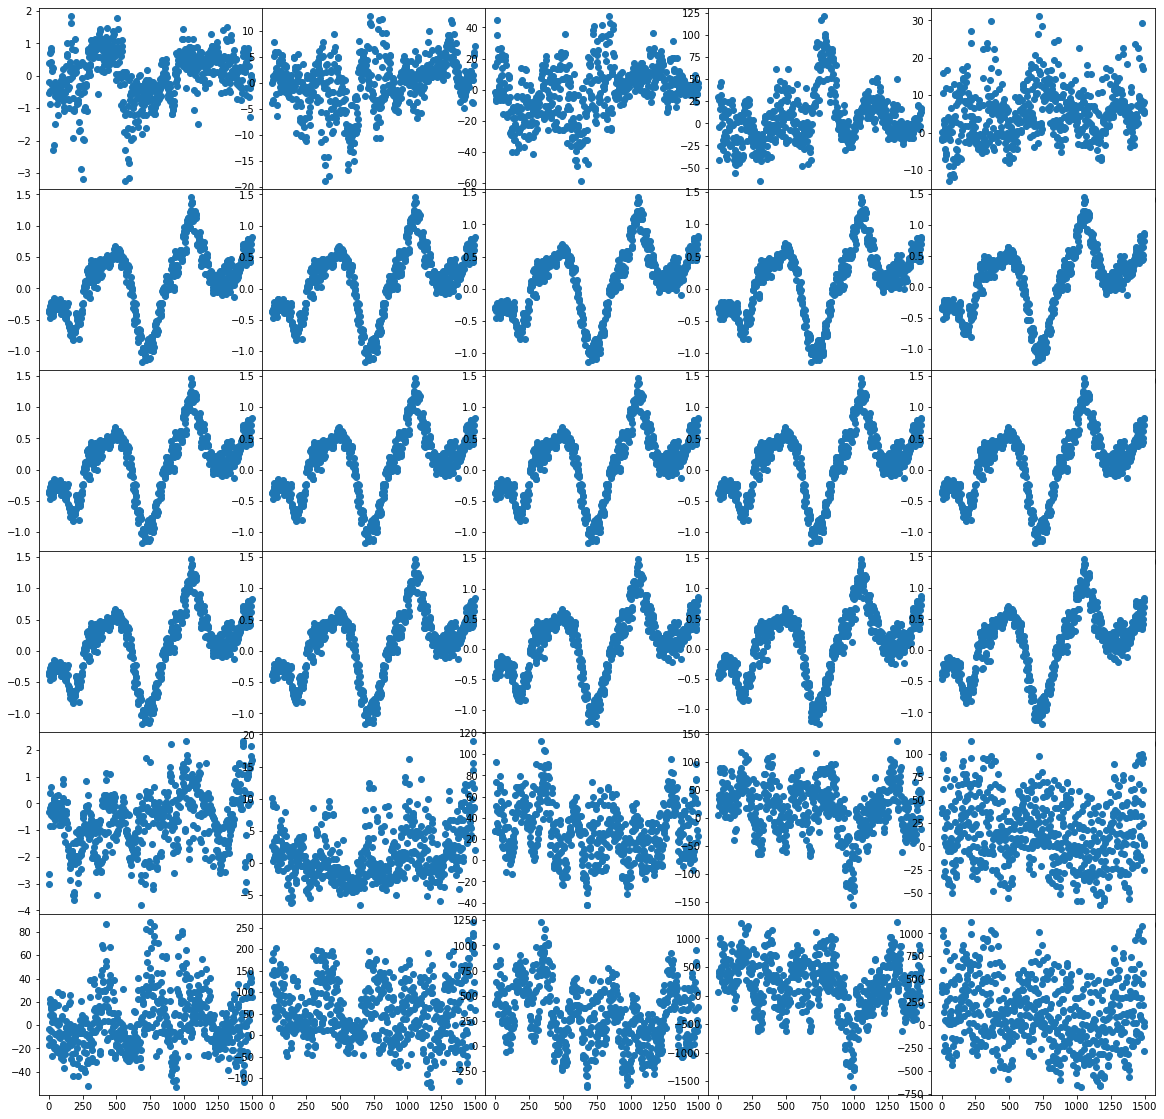

In [609]:
bins = 5
interpols = []
pca_comps = 10
fig, ax = plt.subplots(len(exag_amounts),len(n_to_exag),figsize=(20,20))
exag_interpols = []
for exag_i, exag_indexes in enumerate(exag_indexes_per_n):
    for exag_j, exag_amount in enumerate(exag_amounts): 
        for i in range(pca_comps): # first 4 pcs
            r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])

            bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
            bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 

            # average light curves across bins 
            avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
             for i in range(1,bins+1)]

            avgs = np.array(avgs,dtype=np.float32)
            target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
            target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)

            if i == comp_to_exag:
                # given z, disc path of bin 4, pc 8, add or subtract some amount from exag_index

                print(avgs[0,0].flatten()[exag_index], f'VALUE of pc8,bin0,latent feature {exag_index}')
                print(avgs[bin_to_exag,0].flatten()[exag_index], f'VALUE of pc8,bin {bin_to_exag},latent feature {exag_index}')
                for exag_index in list(exag_indexes):
                    new_i = np.unravel_index(exag_index, (16,64))
                    avgs[bin_to_exag,0,new_i[0],new_i[1]] = avgs[bin_to_exag,0,new_i[0],new_i[1]] + exag_amount


            interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
            if i == comp_to_exag:
                ax[exag_j,exag_i].scatter(interps[bin_to_exag,0,:,0], interps[bin_to_exag,0,:,1])
            #interpols.append(interps)


        #exag_interpols.append(interpols)
    
plt.subplots_adjust(wspace=0, hspace=0) 

In [ ]:
# pushing the value of that bin to make it potentially more obvious what it controls? 

# Exaggerate [n,n_1,n_2] of the main features from PCA 8, proportionally 

In [681]:
comp_to_exag = 0
bin_to_exag = 4
n_to_exag = [2,10,100,500,1000]
exag_indexes_per_n = [np.argsort(pca.components_[comp_to_exag,:])[-n:] for n in n_to_exag]
exag_amounts = [-100,-0.5,0,0.5,100,1000]

-0.13159819 VALUE of pc8,bin0,latent feature 977
-0.028332243 VALUE of pc8,bin 4,latent feature 977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.64it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.19it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.63it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.73it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.75it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.50it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.83it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.62it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.51it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.35it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.50it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.67it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.96it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.53it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.60it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.43it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.41it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.61it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.37it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.65it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.68it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.87it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.67it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.52it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.61it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.41it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.51it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.19it/s]


-0.5473938 VALUE of pc8,bin0,latent feature 41
1.5294491 VALUE of pc8,bin 4,latent feature 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.56it/s]


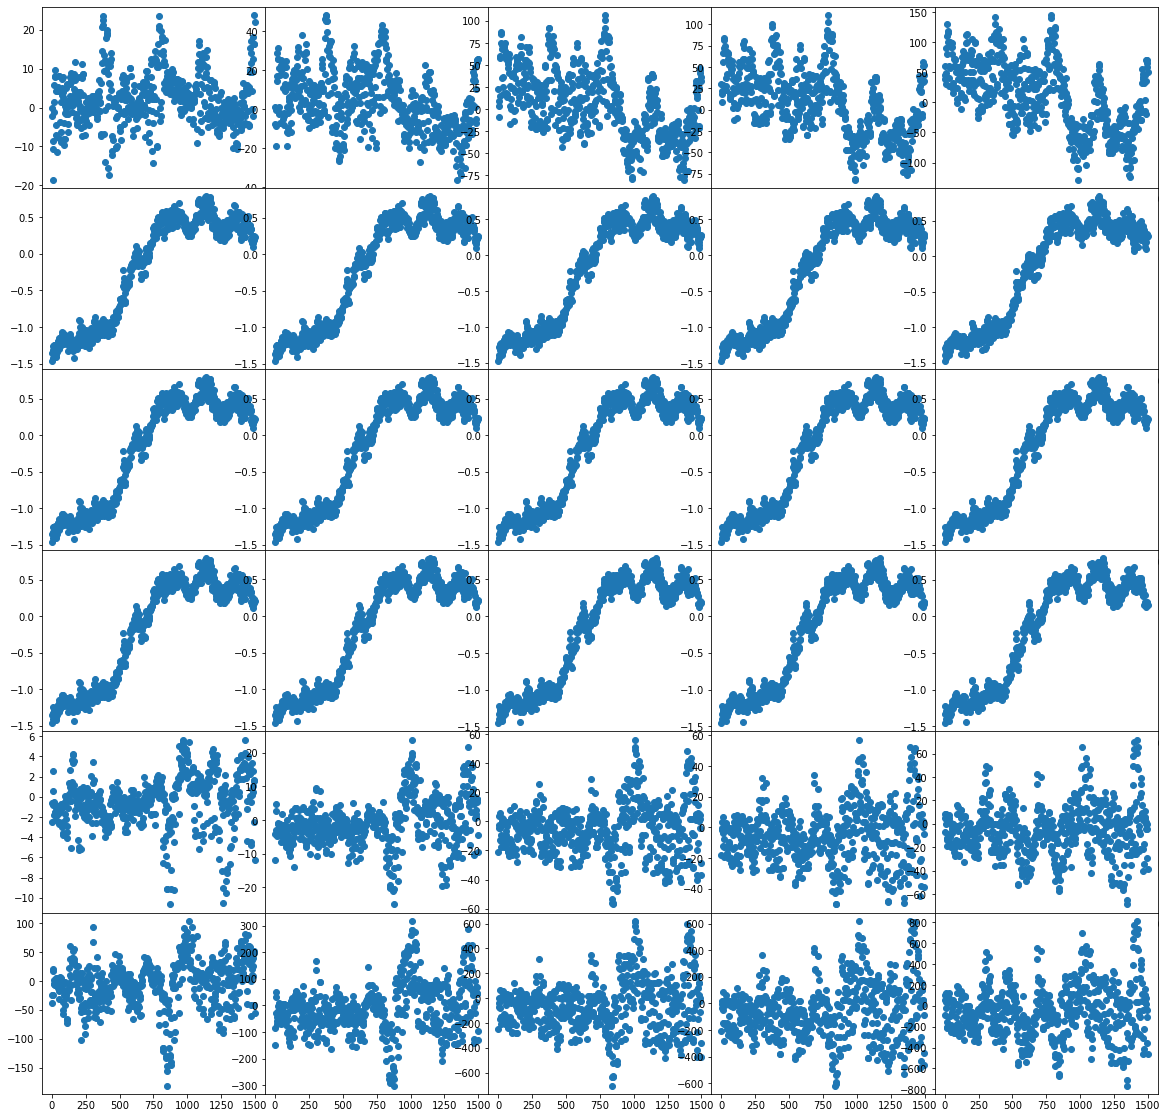

In [682]:
bins = 5
interpols = []
pca_comps = 10
fig, ax = plt.subplots(len(exag_amounts),len(n_to_exag),figsize=(20,20))
exag_interpols = []
for exag_i, exag_indexes in enumerate(exag_indexes_per_n):
    for exag_j, exag_amount in enumerate(exag_amounts): 
        for i in range(pca_comps): # first 4 pcs
            r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])

            bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
            bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 

            # average light curves across bins 
            avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
             for i in range(1,bins+1)]

            avgs = np.array(avgs,dtype=np.float32)
            target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
            target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)

            if i == comp_to_exag:
                # given z, disc path of bin 4, pc 8, add or subtract some amount from exag_index

                
                for exag_index in list(exag_indexes):
                    new_i = np.unravel_index(exag_index, (16,64))
                    avgs[bin_to_exag,0,new_i[0],new_i[1]] = avgs[bin_to_exag,0,new_i[0],new_i[1]] + (avgs[bin_to_exag,0,new_i[0],new_i[1]] * exag_amount)
                    print(avgs[0,0].flatten()[exag_index], f'VALUE of pc{comp_to_exag},bin{bin_to_exag},latent feature {exag_index}')
                    print(avgs[bin_to_exag,0].flatten()[exag_index], f'VALUE of pc8,bin {bin_to_exag},latent feature {exag_index}')


            interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
            if i == comp_to_exag:
                ax[exag_j,exag_i].scatter(interps[bin_to_exag,0,:,0], interps[bin_to_exag,0,:,1])
            #interpols.append(interps)


        #exag_interpols.append(interpols)
    
plt.subplots_adjust(wspace=0, hspace=0) 

In [ ]:
# pushing the value of that bin to make it potentially more obvious what it controls? 